In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from  matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from datetime import datetime
import os
import pickle
import seaborn

In [2]:
%matplotlib inline
seaborn.set(rc={'figure.figsize':(15,8)})
seaborn.set(font_scale=1.2)

In [3]:
TIME_START = "20170101"
TIME_END = "20201231"

In [4]:
def convert_timestamp(string_time):
    temp_time = string_time.split()
    if temp_time[1] == 'mei':
        temp_time[1] = 'may'
    elif temp_time[1] == 'ags':
        temp_time[1] = 'aug'
    elif temp_time[1] == 'okt':
        temp_time[1] = 'oct'
    elif temp_time[1] == 'des':
        temp_time[1] = 'dec'
    fixed_string_time = " ".join(temp_time)
    datetime_obj = datetime.strptime(
        fixed_string_time, "%d %b %Y"
    )
    return datetime_obj.strftime('%Y%m%d')

stock_time_data = dict()
with open('../data/listing_date.csv', 'r') as file:
    reader = csv.reader(file, delimiter='|')
    for row in reader:
        row[2] = convert_timestamp(row[2])
        stock_time_data[row[0]] = row[2]

In [5]:
dump_file = open("../data/stock_price.obj", "rb")
price_list = pickle.load(dump_file)
price_list = {idx: gp.xs(idx, level=0, axis=1).dropna()
              for idx, gp in price_list.groupby(level=0, axis=1)}

In [6]:
def get_output(foldername):
    invalid = []

    df_overall = [None for i in range(5)]
    for filename in tqdm(os.listdir(f'../{foldername}/')):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(f'../{foldername}/', filename), index_col=0)
            if(df.loc[1, 'max'] == 0 or df.loc[1].isnull().values.any()):
                invalid.append(filename.split('.')[0])
                continue
            for index, row in df.iterrows():
                if(df.loc[index, 'max'] != 0 and not df.loc[index].isnull().values.any()):
                    if type(df_overall[index]) == type(None):
                        df_overall[index] = df.loc[index]
                    else:
                        df_overall[index] = pd.concat([df_overall[index], df.loc[index]])

    for idx, df in enumerate(df_overall):
        if type(df) != type(None):
            max_df = df[['max']].reset_index(drop=True)
            min_df = df[['min']].reset_index(drop=True)
            avg_df = df[['avg']].reset_index(drop=True)
            median_df = df[['median']].reset_index(drop=True)
            count_df = df[['count']].reset_index(drop=True)
            df_overall[idx] = pd.concat([
                max_df,
                min_df,
                avg_df,
                median_df,
                count_df
            ], ignore_index=True, axis=1).rename(columns={0: 'max', 1: 'min', 2: 'avg', 3: 'median', 4: 'count'})
    
    return df_overall, invalid

def get_differences(df):
    mean_data = [df[i][['avg']] for i in range(4)]
    temp = [[], []]
    for i in range(len(mean_data[0])):
        for j in range(2):
            temp[j].append(mean_data[j+1].loc[i, 'avg'] - mean_data[j].loc[i, 'avg'])
    return mean_data, temp

In [7]:
def check_invalid(invalid):
    if(len(invalid) == 0):
        print("No invalid data")
    else:
        print(sorted(
        [(i, stock_time_data[i], len(price_list[f'{i}.JK'][TIME_START:TIME_END].Close)) for i in invalid],
        key=lambda k: k[1]
        ))

# Graph-Subset

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 703/703 [00:02<00:00, 263.36it/s]


No invalid data


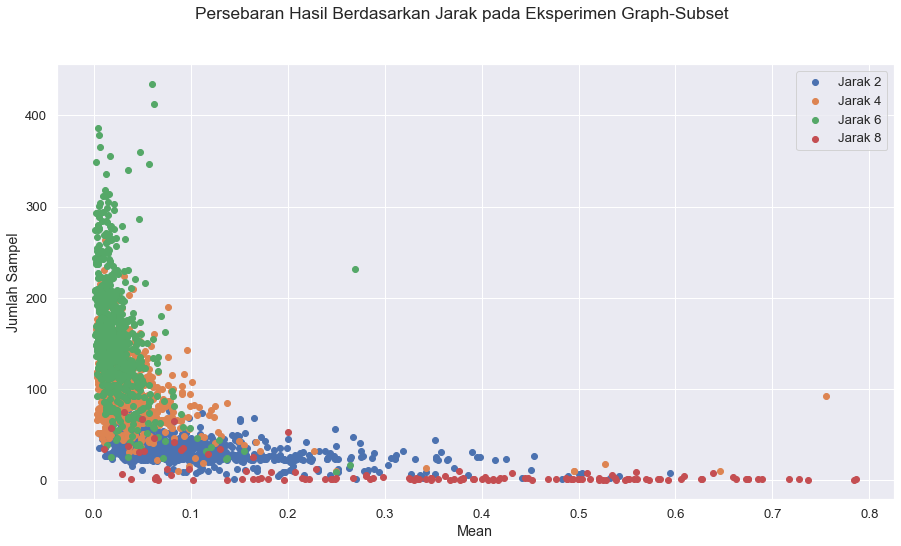

In [8]:
foldername = 'output/output_subset_val'
df_output_subset_val, invalid = get_output(foldername)
check_invalid(invalid)
for i in range(4):
    plt.scatter(x = df_output_subset_val[i][['avg']],
                y = df_output_subset_val[i][['count']],
                label=f"Jarak {i*2+2}"
               )
    plt.legend()
    plt.xlabel('Mean')
    plt.ylabel('Jumlah Sampel')
    plt.suptitle('Persebaran Hasil Berdasarkan Jarak pada Eksperimen Graph-Subset')
    plt.savefig('../img/mean/subset_val-scatter.png', bbox_inches='tight')

# Naive-All

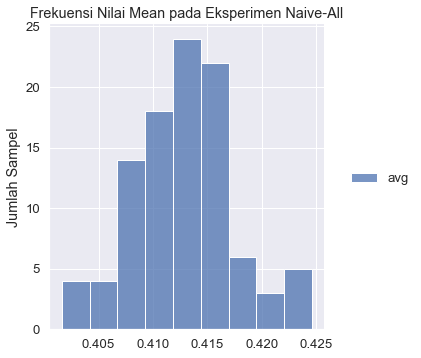

In [9]:
df_output_all_naive = pd.read_csv('../output/output_all_naive/overall_mean.csv', index_col=0)
seaborn.displot(
    data=df_output_all_naive[['avg']]
).set(
    title='Frekuensi Nilai Mean pada Eksperimen Naive-All',
    ylabel="Jumlah Sampel"
).savefig('../img/mean/all_naive-dist.png', bbox_inches='tight')

In [10]:
df_output_all_naive[['avg']].mean()

avg    0.412921
dtype: float64

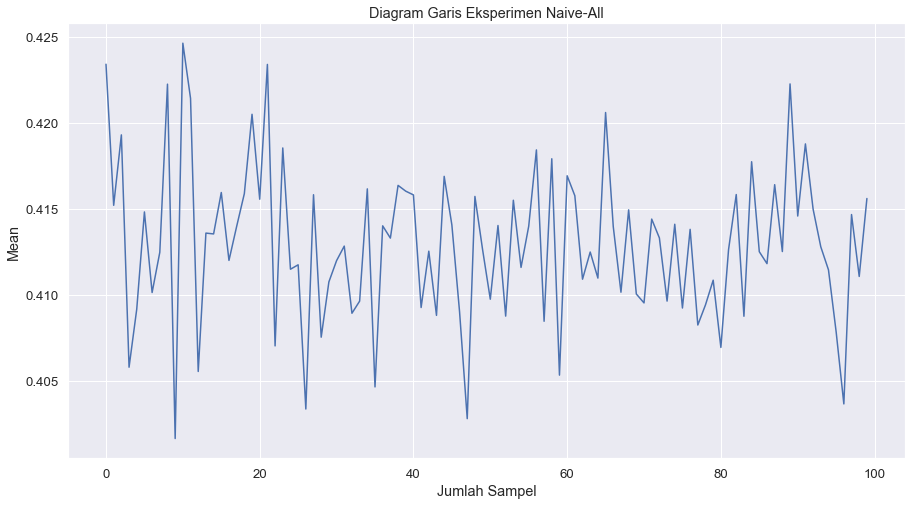

In [11]:
all_naive_lineplot = seaborn.lineplot(
    data = df_output_all_naive[['avg']].reset_index().rename(
        columns={"index": 'count'}
    ),
    x = 'count',
    y = 'avg'
).set(
    title='Diagram Garis Eksperimen Naive-All',
    xlabel='Jumlah Sampel',
    ylabel='Mean'
)

plt.savefig('../img/mean/all_naive-line.png', bbox_inches='tight')

# Naive-Subset

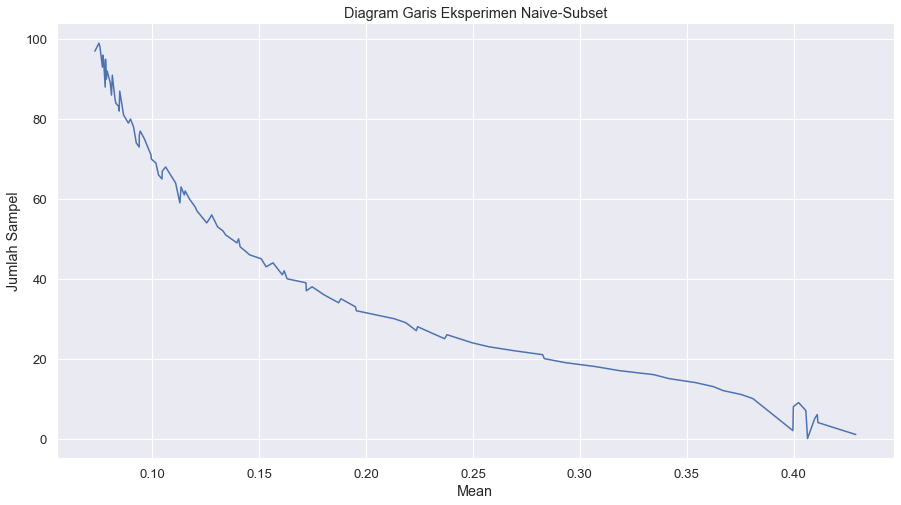

In [12]:
df_output_subset_naive = pd.read_csv('../output/output_subset_naive/overall_mean.csv', index_col=0)
seaborn.lineplot(
    data=df_output_subset_naive[['avg']]
    .reset_index()
    .rename(
        columns={"index": 'count'}
    ),
    x = 'avg',
    y = 'count'
).set(
    xlabel='Mean',
    ylabel="Jumlah Sampel",
    title='Diagram Garis Eksperimen Naive-Subset'
)

plt.savefig('../img/mean/subset_naive-line.png', bbox_inches='tight')

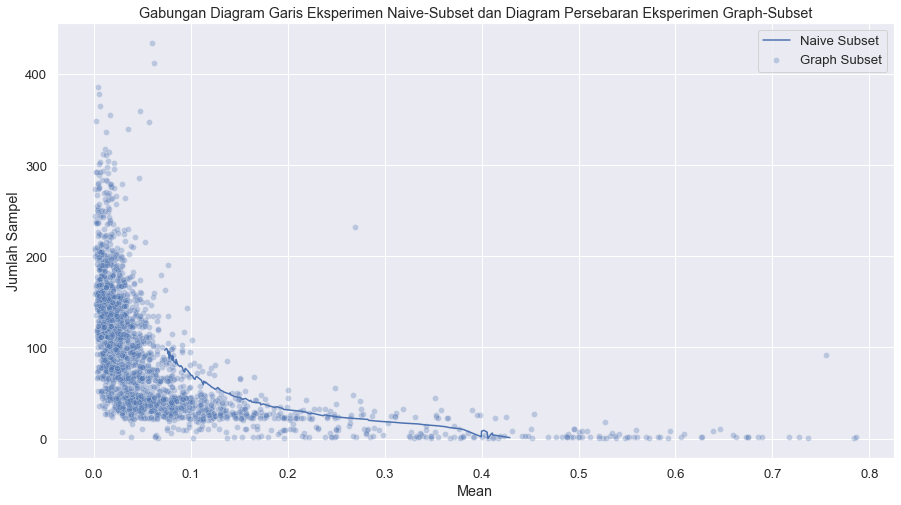

In [13]:
def generate_merged_plot_1(ax=None):
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    lineplot_params = {
        'data': df_output_subset_naive[['avg']].reset_index().rename(columns={"index": 'count'}),
        'x': 'avg',
        'y': 'count',
        'label': 'Naive Subset'
    }   
    scatterplot_params = {
        'data': merged_df,
        'x': 'avg',
        'y': 'count',
        'alpha': 0.3,
        'label': 'Graph Subset'
    }
    if(ax is not None):
        lineplot_params['ax'] = ax
        scatterplot_params['ax'] = ax
    seaborn.lineplot(**lineplot_params)
    seaborn.scatterplot(
        **scatterplot_params
    ).set(
        xlabel='Mean',
        ylabel='Jumlah Sampel',
        title='Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Persebaran Eksperimen Graph-Subset'
    )

generate_merged_plot_1()
plt.savefig('../img/mean/subset_naive-line-merged.png', bbox_inches='tight')

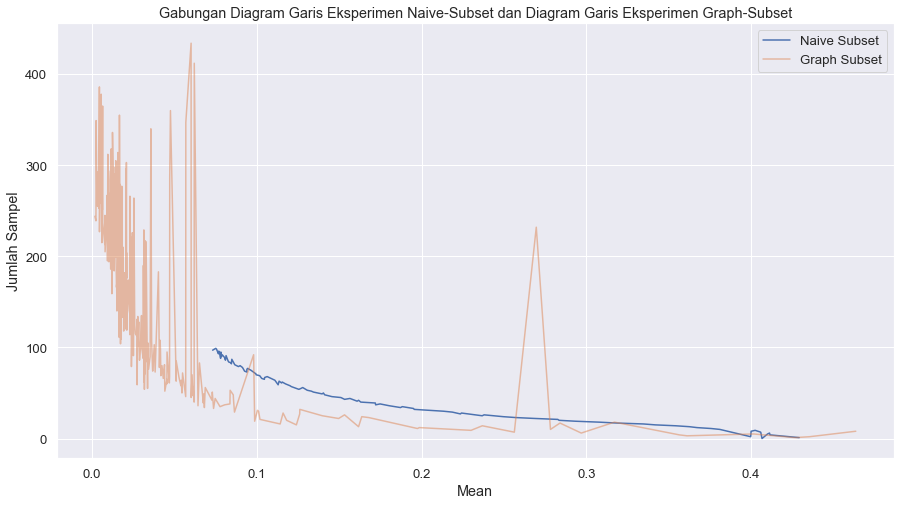

In [14]:
def generate_merged_plot_2(ax=None):
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean()

    lineplot_params_1 = {
        'data': df_output_subset_naive[['avg']].reset_index().rename(columns={"index": 'count'}),
        'x': 'avg',
        'y': 'count',
        'label': 'Naive Subset'
    }
    lineplot_params_2 = {
        'data': merged_df,
        'x': 'avg',
        'y': 'count',
        'alpha': 0.5,
        'label': 'Graph Subset'
    }
    if(ax is not None):
        lineplot_params_1['ax'] = ax
        lineplot_params_2['ax'] = ax

    seaborn.lineplot(**lineplot_params_1)

    seaborn.lineplot(
        **lineplot_params_2
    ).set(
        xlabel='Mean',
        ylabel='Jumlah Sampel',
        title='Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Garis Eksperimen Graph-Subset'
    )

generate_merged_plot_2()

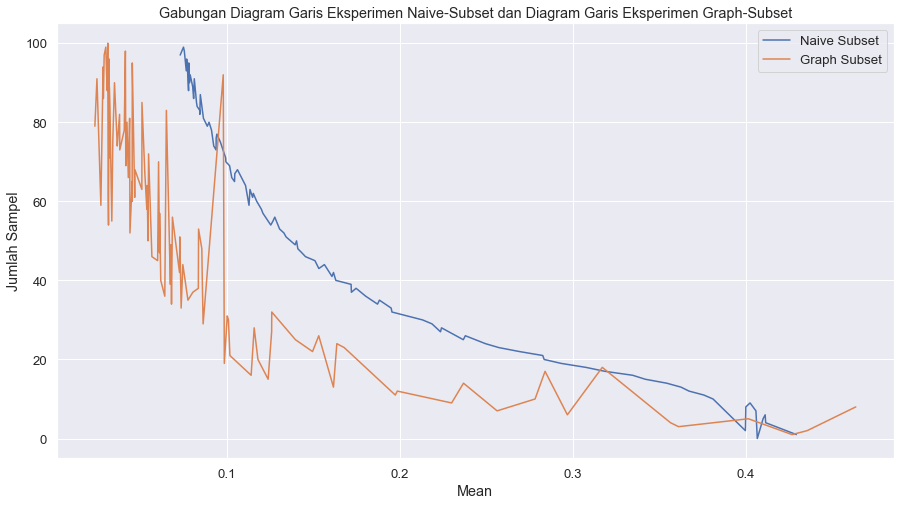

In [15]:
def generate_merged_plot_3(ax=None):
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean().reset_index()

    lineplot_params_1 = {
        'data': df_output_subset_naive[['avg']].reset_index().rename(columns={"index": 'count'}),
        'x': 'avg',
        'y': 'count',
        'label': 'Naive Subset'
    }
    lineplot_params_2 = {
        'data': merged_df[merged_df['count'] <= 100],
        'x': 'avg',
        'y': 'count',
        'label': 'Graph Subset'
    }
    if(ax is not None):
        lineplot_params_1['ax'] = ax
        lineplot_params_2['ax'] = ax

    seaborn.lineplot(**lineplot_params_1)

    seaborn.lineplot(
        **lineplot_params_2
    ).set(
        xlabel='Mean',
        ylabel='Jumlah Sampel',
        title='Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Garis Eksperimen Graph-Subset'
    )

generate_merged_plot_3()
plt.savefig('../img/mean/subset_naive-mean-line.png', bbox_inches='tight')

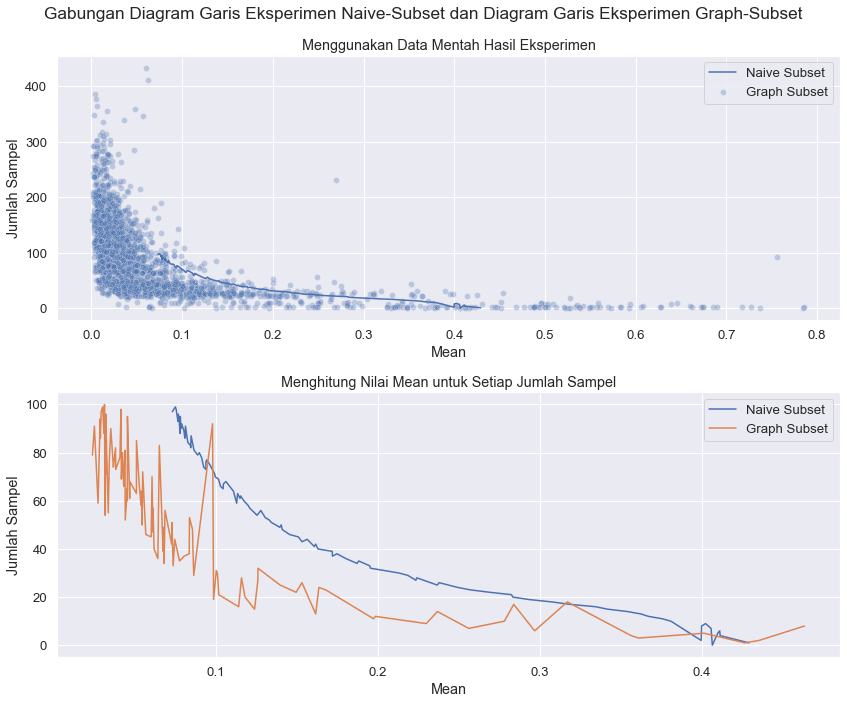

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Garis Eksperimen Graph-Subset')
generate_merged_plot_1(axes[0])
generate_merged_plot_3(axes[1])
axes[0].title.set_text('Menggunakan Data Mentah Hasil Eksperimen')
axes[1].title.set_text('Menghitung Nilai Mean untuk Setiap Jumlah Sampel')

fig.tight_layout()
plt.savefig('../img/mean/subset_naive-mean-line.png', bbox_inches='tight')

Mean Difference   -0.497502
dtype: float64


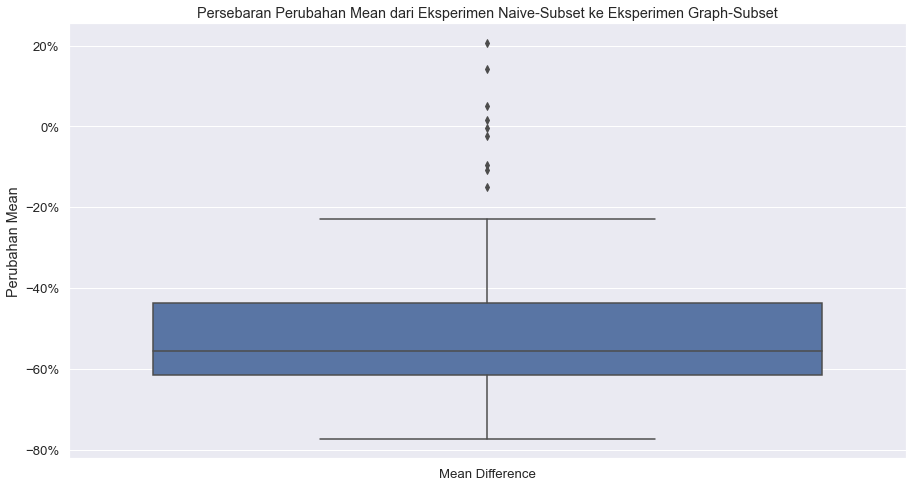

In [18]:
def plot_difference_percentage():
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean().reset_index()
    divided_df = (merged_df[merged_df['count'] <= 100][['avg']] - df_output_subset_naive[['avg']]) / df_output_subset_naive[['avg']]
    divided_df.index = divided_df.index + 1
    divided_df = divided_df.reset_index().rename(
            columns={"avg": "Mean Difference"}
    )

    ax = seaborn.boxplot(
        data=divided_df[['Mean Difference']]
    )

    ax.set(
        ylabel='Perubahan Mean',
        title='Persebaran Perubahan Mean dari Eksperimen Naive-Subset ke Eksperimen Graph-Subset'
    )

    ax.yaxis.set_major_formatter(PercentFormatter(1))
    print(divided_df[['Mean Difference']].mean())

plot_difference_percentage()
plt.savefig('../img/mean/subset_naive-mean-percentdiff-line.png', bbox_inches='tight')

# Graph-All

In [ ]:
foldername = 'output/output_all_val'
df_output_all_val, invalid = get_output(foldername)
check_invalid(invalid)
for i in range(4):
    print(len(df_output_all_val[i]))

In [ ]:
for i in range(4):
    plt.scatter(
        x = df_output_all_val[i][['avg']],
        y = df_output_all_val[i][['count']],
        label=f"Jarak {i*2+2}"
    )
    plt.legend()
    plt.xlabel('Mean')
    plt.ylabel('Jumlah Sampel')
    
plt.suptitle('Persebaran Hasil pada Eksperimen Graph-All')
plt.savefig('../img/mean/all_val-scatter.png', bbox_inches='tight')

In [ ]:
mean_data, differences_data = get_differences(df_output_all_val)
print(mean_data[0].mean(), mean_data[1].mean(), mean_data[2].mean(), mean_data[3].mean())

seaborn.boxplot(
    data=mean_data
).set(
    xlabel='Jarak',
    ylabel='Mean',
    title='Rentang Nilai Mean Berdasarkan Jarak pada Eksperimen Graph-All',
)
plt.xticks([0, 1, 2, 3], [2, 4, 6, 8])
plt.savefig('../img/mean/all_val_mean-box.png', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Frekuensi Setiap Mean Berdasarkan Jarak pada Eksperimen Graph-All')
for i in range(4):
    seaborn.histplot(ax = axes[i//2, i%2], data=mean_data[i])
    axes[i//2, i%2].set_title(f"Jarak {i*2 + 2}")
    axes[i//2, i%2].set(xlabel="Mean", ylabel="Jumlah")
plt.savefig('../img/mean/all_val_mean-distribution.png', bbox_inches='tight')

In [ ]:
seaborn.boxplot(
    data=differences_data
).set(
    ylabel='Selisih Mean',
    title='Persebaran Nilai Peningkatan Mean Untuk Setiap Instans Data'
)
plt.xticks([0, 1], ['Jarak 2 Ke Jarak 4', 'Jarak 4 Ke Jarak 6'])
plt.savefig('../img/mean/all_val_differences-box.png', bbox_inches='tight')

In [ ]:
print(np.mean(differences_data[0]))
print(np.mean(differences_data[1]))

In [ ]:
seaborn.kdeplot(data=mean_data[0])
seaborn.kdeplot(data=mean_data[1])
seaborn.kdeplot(data=mean_data[2])
plt.ylabel('Densitas')
plt.xlabel('Mean')
plt.suptitle('Diagram KDE Mean pada Eksperimen Graph-All')
plt.savefig('../img/mean/all_val_mean-displot.png', bbox_inches='tight')

# Graph-Random

In [ ]:
foldername = 'output/output_random_val'
df_output_random_val, invalid = get_output(foldername)
check_invalid(invalid)

In [ ]:
mean_data, differences_data = get_differences(df_output_random_val)
print(mean_data[0].mean(), mean_data[1].mean(), mean_data[2].mean())

seaborn.boxplot(
    data=mean_data
).set(
    xlabel='Jarak',
    ylabel='Mean',
    xticklabels=[2, 4, 6, 8]
)
plt.savefig('../img/mean/random_val_mean-box.png', bbox_inches='tight')

In [ ]:
seaborn.boxplot(data=differences_data)
plt.xticks([0, 1], ['Jarak 4 Dengan Jarak 2', 'Jarak 6 Dengan Jarak 4'])
plt.ylabel('Selisih Mean')
plt.savefig('../img/mean/random_val_differences-box.png')

In [ ]:
seaborn.kdeplot(data=mean_data[0])
seaborn.kdeplot(data=mean_data[1])
seaborn.kdeplot(data=mean_data[2])
plt.ylabel('Densitas')
plt.xlabel('Mean')

plt.suptitle('Diagram KDE Mean pada Eksperimen Graph-Random')
plt.savefig('../img/mean/random_val_mean-displot.png')